### Therapeutics Data Commons: ADMET
### Show Results


In [2]:
from utils import load_json
from tdc_bechmarks_july2025 import benchmark_results, get_sota_df, add_results_to_benchmark, merge_dfs, create_results_df, create_results_df, merge_dfs

tabpfn_results_dict = load_json("results_tabpfn.json")
xgboost_results_dict = load_json("results_xgboost.json")
previous_sota_df = get_sota_df(benchmark_results)

# Add TabPFNv2 and XGBoost results to the benchmark results
benchmark_results = add_results_to_benchmark(benchmark_results, tabpfn_results_dict, "RDKit2D + TabPFNv2")
benchmark_results = add_results_to_benchmark(benchmark_results, xgboost_results_dict, "RDKit2D + XGBoost")

# Get MiniMol and MolE results from the benchmark results
# Every value of MolE is from the paper, they have not submitted to the leaderboard nor have a GitHub with results
mole_results_dict = {k: v['leaderboard']['MolE'] for k, v in benchmark_results.items() if 'MolE' in v['leaderboard']}
minimol_results_dict = {k: v['leaderboard']['MiniMol'] for k, v in benchmark_results.items() if 'MiniMol' in v['leaderboard']}

tabpfn_df = create_results_df(tabpfn_results_dict, "RDKit2D + TabPFNv2 ")
minimol_df = create_results_df(minimol_results_dict, "MiniMol ")
mole_df = create_results_df(mole_results_dict, "MolE ")
xgb_df = create_results_df(xgboost_results_dict, "RDKit2D + XGBoost ")

results = merge_dfs([previous_sota_df, minimol_df, mole_df, tabpfn_df, xgb_df])

print(f"MiniMol mean rank:     {results['MiniMol position'].mean():.2f}")
print(f"MolE mean rank:        {results['MolE position'].mean():.2f}")
print(f"TabPFNv2 mean rank:     {results['RDKit2D + TabPFNv2 position'].mean():.2f}")
print(f"XGBoost mean rank:    {results['RDKit2D + XGBoost position'].mean():.2f}")
print()

print(f"TabPFNv2 on 1º:         {(results['RDKit2D + TabPFNv2 position'] == 1).sum()}/{results.shape[0]} times")
print(f"TabPFNv2 > MiniMol:     {(results['RDKit2D + TabPFNv2 position'] < results['MiniMol position']).sum()}/{results.shape[0]} times")
print(f"TabPFNv2 > MolE:       {(results['RDKit2D + TabPFNv2 position'] < results['MolE position']).sum()}/{results.shape[0]} times")
print(f"TabPFNv2 > XGBoost:    {(results['RDKit2D + TabPFNv2 position'] < results['RDKit2D + XGBoost position']).sum()}/{results.shape[0]} times")

MiniMol mean rank:     4.82
MolE mean rank:        9.86
TabPFNv2 mean rank:     7.14
XGBoost mean rank:    13.14

TabPFNv2 on 1º:         3/22 times
TabPFNv2 > MiniMol:     9/22 times
TabPFNv2 > MolE:       13/22 times
TabPFNv2 > XGBoost:    19/22 times


## Critical Difference Diagram

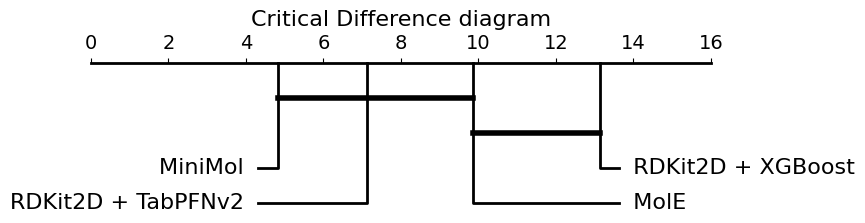

In [19]:
import scikit_posthocs as sp
#from scikit_posthocs import graph_cd
import matplotlib.pyplot as plt
from math import sqrt

positions_cd = results[list(results.filter(regex='position'))] 
# Keep just the name of the models
positions_cd.columns = [" ".join(s.split()[:-1]) for s in positions_cd.columns]
mean_ranks = positions_cd.mean()

nemenyi = sp.posthoc_nemenyi_friedman(positions_cd)


# Ejemplo simple
fig, ax = plt.subplots(figsize=(8, 2))
ax.set_title('Critical Difference diagram', fontsize=16)
# Cambiar el grosor de los ejes
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Cambia 2 por el grosor que quieras
ax.tick_params(axis='x', labelsize=14)  # eje x
ax.tick_params(axis='y', labelsize=14)  # eje y

sp.critical_difference_diagram(
    ranks=mean_ranks,
    sig_matrix=nemenyi,
    label_fmt_left='{label}  ',
    label_fmt_right='  {label}',
    label_props={'fontsize': 16},
    color_palette =['black']*len(mean_ranks),
    marker_props={'s': 0},
    elbow_props={'linewidth': 2},
    crossbar_props ={'linewidth': 4},
    text_h_margin = 0.5,

)

plt.xlim(0, 16) 
# pdf for the poster, png for the website
plt.savefig("results/critical_difference_diagram.pdf", bbox_inches="tight")
plt.savefig("results/critical_difference_diagram.png", bbox_inches="tight")
plt.show()


### Check how many parameters the model has

In [ ]:
import torch

ckpt_path = "tabpfn_ckpts/"
ckpts = {'Regressor': 'tabpfn-v2-regressor.ckpt',
         'Classifier': 'tabpfn-v2-classifier-finetuned-zk73skhh.ckpt'}

for task, ckpt_name in ckpts.items():
    ckpt = torch.load(ckpt_path + ckpt_name, map_location='cpu')

    state_dict = ckpt.get("state_dict", ckpt)
    total_params = sum(p.numel() for p in state_dict.values() if isinstance(p, torch.Tensor))

    print(f"{task} total params: {total_params:,}")

Regressor total params: 11,091,865
Classifier total params: 7,244,554
